# 🌍 Fields of The World: Country-Scale Field Boundary Predictions

This tutorial explains how to access country-scale Sentinel-2 mosaics and AI-derived field boundary probability maps (produced using FTW models) for Japan 🇯🇵, Mexico 🇲🇽, Rwanda 🇷🇼, South Africa 🇿🇦, and Switzerland 🇨🇭.

These cloud-native Zarr datasets were generated by the FTW team on the Wherobots RasterFlow platform. It includes input imagery (seasonal mosaics) and raw model outputs (softmax predictions).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fieldsoftheworld/iclr2026-ml4rs-tutorial/blob/main/2.0-country-scale-field-boundary-predictions.ipynb)

# Table of Contents

* [💻 Software Requirements](#software-requirements)
* [🌏 Dataset Coverage](#dataset-coverage)
* [📦 Data Structure (Zarr)](#data-structure)
* [🔧 Usage (Data Access)](#usage)
* [1. 🎯 Setup and Define AOI](#setup-aoi)
* [2. 📂 Open Zarr Stores](#open-zarr)
* [3. 📸 Slicing and Visualizing](#slicing-visualizing)
* [4. 💾 Convert to Cloud-Optimized GeoTIFF (COG)](#convert-cog)
* [5. 🧹 Post-process and Polygonize](#post-process)
  * [🏠 Filter by Land Cover](#filter-lulc)
  * [🟫 Polygonize Boundaries](#polygonize)
  * [🗾 Visualize on Interactive Map](#visualize-map)

<a name="software-requirements"></a>
# 💻 Software Requirements

This notebook requires Python (>= 3.12 and < 3.14) and an environment to run Jupyter notebooks.

All requirements can be installed through `pip` by running:
```bash
pip install .
```

If you are using Conda, we provide a lightweight environment file `environment.yml`. You can install it by running:
```bash
# Install environment
conda env create -f environment.yml
# Activate environment
conda activate ftw-tutorial
```

<!--

All tutorial submissions must have a separate `requirements.txt` file stating all dependencies and versions for software, packages, or tooling used in the tutorial. This file allows tutorial users who would like to run a copy of the notebook locally with all dependencies needed to create their own virtual environment/IPython kernel.

In bash you may create a `requirements.txt` by typing the following command:

`pip freeze > requirements.txt'

Avoid undocumented dependencies.

We encourage explicitly printing out your dependencies using a notebook extension such as [watermark](https://github.com/rasbt/watermark) at the bottom of your notebook.

Within the notebook, there must be a cell which includes the necessary directory structure to retrieve files or data using relative paths for ease of use. If data is private, please provide a similar public sample for those that would like to reproduce or extend your work. Instructions and imports with versioning must be provided and clearly labeled at the top.

Document the beginning and end date of your analysis to contextualize the development stage of the notebook in the event that highlighted packages or content is updated in the future.
-->

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "TRUE"  # when multiple copies of OpenMP are found we get a warning, this silences it
)

os.makedirs("data", exist_ok=True)

# If you have GDAL installed in your environment, these environment variables can cause issues
# with rasterio and fiona. So we unset them here.
for entry in ["GDAL_DATA", "PROJ_NETWORK", "PROJ_DATA", "GDAL_DRIVER_PATH"]:
    if entry in os.environ:
        del os.environ[entry]

# If the notebook was opened in Colab then clone the source repo and install required packages
if "google.colab" in str(get_ipython()):
    !git clone https://github.com/fieldsoftheworld/iclr2026-ml4rs-tutorial.git
    os.chdir("iclr2026-ml4rs-tutorial")

    !pip install .

<a name="dataset-coverage"></a>
## 🌏 Dataset Coverage

The dataset covers five countries in diverse agricultural systems across two seasons and two years (2023 and 2024), totaling 4.76 million square kilometers. This data represents the outcomes of the inference stage of models produced using FTW.

| Country | Area Processed (M sq km) | Median Area of Predicted Fields (ha) |
| :-- | :-- | :-- |
| Mexico 🇲🇽 | 2.39 | 0.09 |
| South Africa 🇿🇦 | 1.60 | 0.07 |
| Japan 🇯🇵 | 0.65 | 0.19 |
| Switzerland 🇨🇭 | 0.09 | 0.28 |
| Rwanda 🇷🇼 | 0.02 | 0.06 |

<a name="data-structure"></a>
## 📦 Data Structure (Zarr)

The data is hosted as cloud-optimized Zarr stores. Each store corresponds to a country and contains high-resolution raster arrays with time coordinates for 2023 and 2024:

1. Sentinel-2 mosaics 🛰️
- Bi-temporal composites (Planting and Harvest seasons)
- Resolution: 10m
- Bands: RGB + NIR
- Valid-pixel composites filtered by cloud cover

2. Model predictions 🧠
- Raw softmax probabilities for background, field, and field boundary classes
- Raw logits support custom thresholding, watershedding, or vectorization parameters (see `ftw inference polygonize` options in FTW CLI)

<a name="usage"></a>
## 🔧 Usage (Data Access)

The dataset uses cloud-native Zarr format, which allows access to subsets for analysis without downloading the entire dataset using Python libraries like xarray and zarr.

<a name="setup-aoi"></a>
## 1. 🎯 Setup and Define AOI

Define a sample area of interest (AOI) over Japan.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import xarray as xr

src_crs = "EPSG:3857"
planting_bands = ["s2med_planting:B04", "s2med_planting:B03", "s2med_planting:B02"]
harvest_bands = ["s2med_harvest:B04", "s2med_harvest:B03", "s2med_harvest:B02"]
norm = 3000

# Define a bounding box (Japan)
xmin, ymin = (140.029187, 39.520088)
xmax, ymax = (140.403203, 39.215519)
box = shapely.box(xmin, ymin, xmax, ymax)
aoi = gpd.GeoDataFrame(geometry=[box], crs="EPSG:4326")
aoi = aoi.to_crs(src_crs)

<a name="open-zarr"></a>
## 2. 📂 Open Zarr Stores

In [3]:
mosaic_path = "https://data.source.coop/wherobots/fields-of-the-world/mosaics/japan.zarr/"
mosaic = xr.open_zarr(mosaic_path)
mosaic

<xarray.Dataset> Size: 3TB
Dimensions:      (time: 2, band: 10, y: 207218, x: 179611)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-01-01 2024-01-01
  * band         (band) <U29 1kB 's2med_harvest:B02' ... 's2med_planting:N_VA...
  * y            (y) float64 2MB 5.709e+06 5.709e+06 ... 3.637e+06 3.637e+06
  * x            (x) float64 1MB 1.441e+07 1.441e+07 ... 1.62e+07 1.62e+07
    spatial_ref  int64 8B ...
Data variables:
    variables    (time, band, y, x) float32 3TB dask.array<chunksize=(1, 1, 4096, 4096), meta=np.ndarray>

In [4]:
pred_path = "https://data.source.coop/wherobots/fields-of-the-world/predictions/japan.zarr/"
predictions = xr.open_zarr(pred_path)
predictions

<xarray.Dataset> Size: 893GB
Dimensions:      (time: 2, band: 3, y: 207218, x: 179611)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-01-01 2024-01-01
  * band         (band) <U14 168B 'background' 'field' 'field-boundary'
  * y            (y) float64 2MB 5.709e+06 5.709e+06 ... 3.637e+06 3.637e+06
  * x            (x) float64 1MB 1.441e+07 1.441e+07 ... 1.62e+07 1.62e+07
    spatial_ref  int64 8B ...
Data variables:
    variables    (time, band, y, x) float32 893GB dask.array<chunksize=(1, 3, 4096, 4096), meta=np.ndarray>

<a name="slicing-visualizing"></a>
## 3. 📸 Slicing and Visualizing

Lazily load data within the AOI for a specific year and visualize inputs alongside model outputs.

In [20]:
time = "2024-01-01"

p_crop = mosaic.sel(time=time, band=planting_bands).rio.clip_box(*aoi.geometry.total_bounds) / norm
h_crop = mosaic.sel(time=time, band=harvest_bands).rio.clip_box(*aoi.geometry.total_bounds) / norm
pred_crop = predictions.sel(time=time, band="field").rio.clip_box(*aoi.geometry.total_bounds)

p_crop = p_crop.clip(0, 1).to_array().squeeze().compute()
h_crop = h_crop.clip(0, 1).to_array().squeeze().compute()
pred_crop = pred_crop.to_array().squeeze().compute()

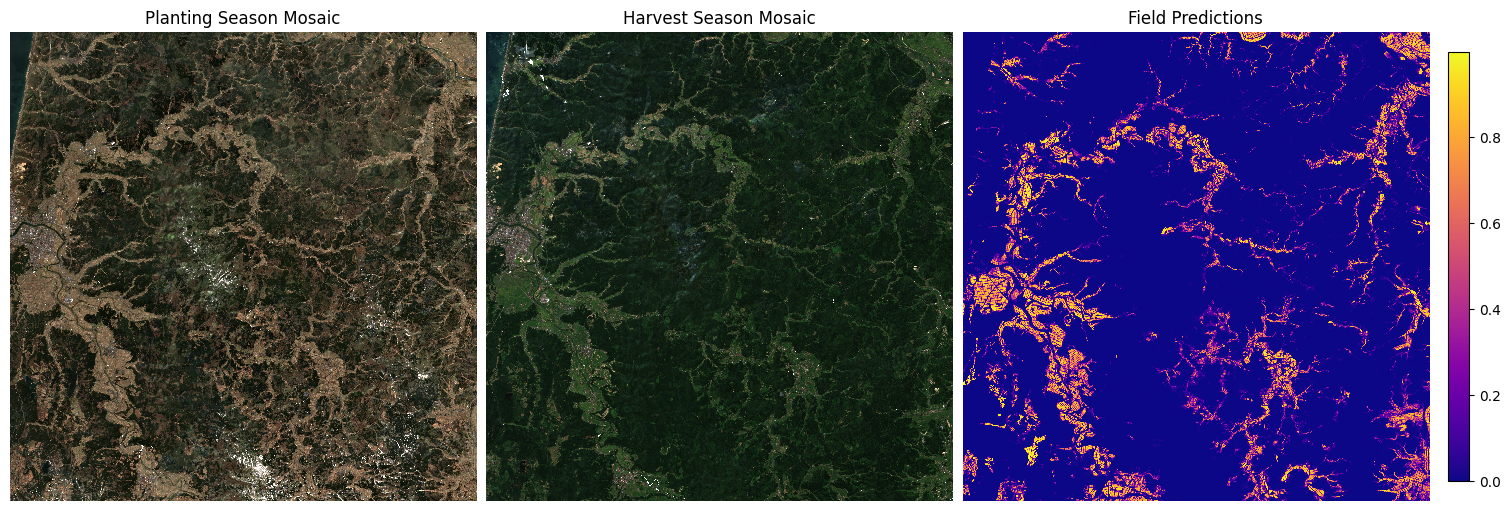

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

p_crop.plot.imshow(ax=axes[0])
axes[0].axis("off")
axes[0].set_title("Planting Season Mosaic")

h_crop.plot.imshow(ax=axes[1])
axes[1].axis("off")
axes[1].set_title("Harvest Season Mosaic")

im = pred_crop.plot.imshow(ax=axes[2], cmap="plasma", add_colorbar=False)
axes[2].axis("off")
axes[2].set_title("Field Predictions")

fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
plt.show()

<a name="convert-cog"></a>
## 4. 💾 Convert to Cloud-Optimized GeoTIFF (COG)

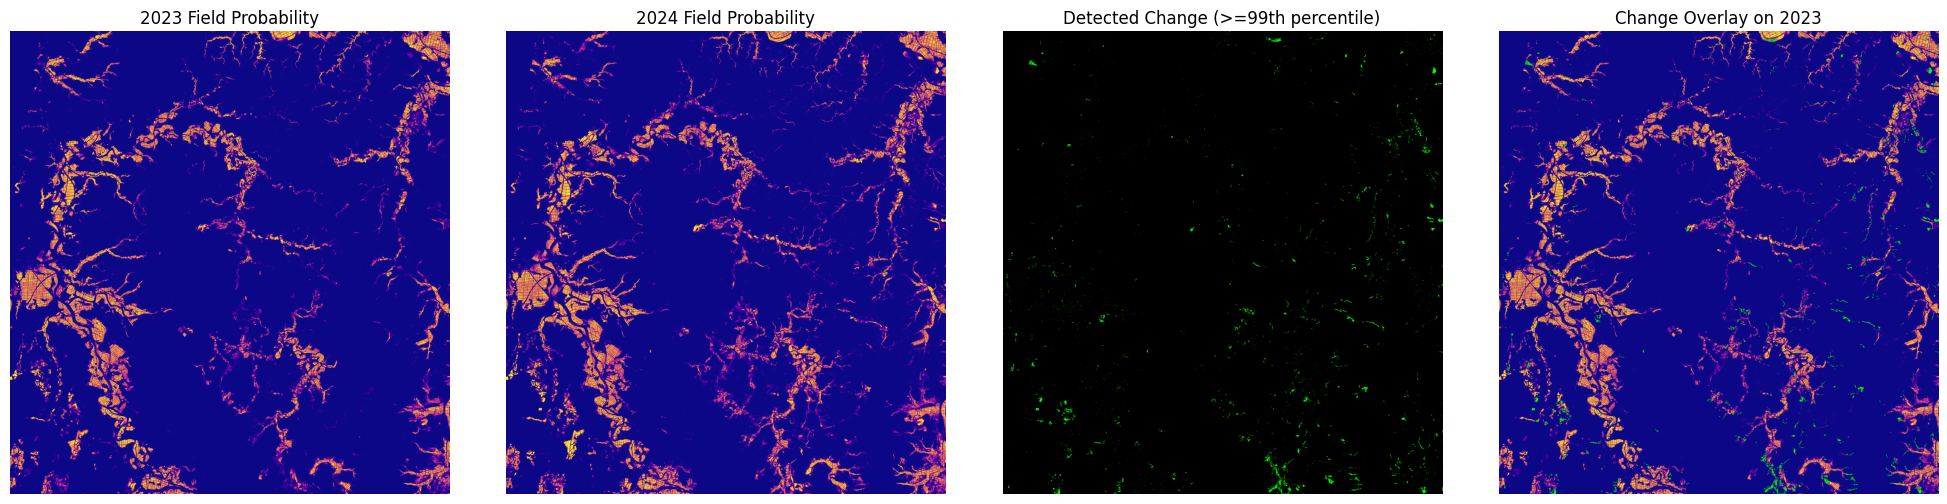

In [19]:
# Fetch predictions for both years
pred_2023 = predictions.sel(time="2023-01-01", band="field")
pred_2023 = pred_2023.rio.clip_box(*aoi.geometry.total_bounds).to_array().squeeze().to_numpy()

pred_2024 = predictions.sel(time="2024-01-01", band="field")
pred_2024 = pred_2024.rio.clip_box(*aoi.geometry.total_bounds).to_array().squeeze().to_numpy()

# Calculate difference
diff = pred_2024 - pred_2023

# Simple thresholding (>= 99th percentile)
pct = 99
threshold = np.percentile(diff[diff > 0], pct)
change = diff.clip(0, 1)
change[change >= threshold] = 1
change[change < threshold] = 0

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(pred_2023, vmin=0, vmax=1, cmap="plasma")
axes[0].set_title("2023 Field Probability")
axes[0].axis("off")

axes[1].imshow(pred_2024, vmin=0, vmax=1, cmap="plasma")
axes[1].set_title("2024 Field Probability")
axes[1].axis("off")

green_cmap = plt.cm.colors.ListedColormap([[0, 0, 0], [0, 1, 0]])
axes[2].imshow(change, vmin=0, vmax=1, cmap=green_cmap)
axes[2].set_title("Detected Change (>=99th percentile)")
axes[2].axis("off")

img = plt.cm.plasma(pred_2023)
img[change == 1, :3] = [0, 1, 0]
axes[3].imshow(img, vmin=0, vmax=1)
axes[3].set_title("Change Overlay on 2023")
axes[3].axis("off")

plt.tight_layout()
plt.show()

Before saving, we need to threshold the probability maps to create binary masks. The polygonization step expects binary values (0 or 1) indicating whether each pixel is a field or not.

In [20]:
import rasterio
from rasterio import Affine
from rasterio.transform import from_bounds

# Threshold the probability maps to create binary masks
# Using 0.5 as the threshold - pixels with probability >= 0.5 are considered fields
threshold = 0.5
pred_2023_binary = (pred_2023 >= threshold).astype(np.uint8)
pred_2024_binary = (pred_2024 >= threshold).astype(np.uint8)

# Get bounds and dimensions from the AOI
bounds = aoi.geometry.total_bounds  # In EPSG:3857
height, width = pred_2023.shape

# Create affine transform for georeferencing
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)


def write_geotiff(
    array: np.ndarray, output_path: str, height: int, width: int, crs: str, transform: Affine
) -> None:
    """Write a numpy array to a georeferenced GeoTIFF file."""
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        compress="lzw",
    ) as dst:
        dst.write(array, 1)


# Write all three arrays to GeoTIFF files (using binary masks for 2023 and 2024)
write_geotiff(pred_2023_binary, "data/pred_2023.tif", height, width, src_crs, transform)
write_geotiff(pred_2024_binary, "data/pred_2024.tif", height, width, src_crs, transform)
write_geotiff(change, "data/change.tif", height, width, src_crs, transform)

print("Saved georeferenced GeoTIFFs (binary masks):")
print("  - data/pred_2023.tif")
print("  - data/pred_2024.tif")
print("  - data/change.tif")

Saved georeferenced GeoTIFFs (binary masks):
  - data/pred_2023.tif
  - data/pred_2024.tif
  - data/change.tif


<a name="post-process"></a>
## 5. 🧹 Post-process and polygonize

<a name="filter-lulc"></a>
### 🏠 Filter predicted by land cover
FTW models are known to make some commission errors, segmenting non-crop land cover (like pasture) as "fields". We can try to filter out some of these erroneous predictions using an existing land cover map.

This function uses the Impact Observatory landcover map by default, but you can also use ESA WorldCover by setting the `--collection_name` argument. If you'd like to see the cropland mask from the land cover map that's being used by the FTW CLI to filter the polygons, you can set the `--save_lulc_tif` flag.


In [21]:
!ftw inference filter-by-lulc --help

Usage: ftw inference filter-by-lulc [OPTIONS] INPUT

  Filter the output raster in GeoTIFF format by LULC mask.

Options:
  -o, --out PATH                  Output filename for the (filtered)
                                  polygonized data. Defaults to the name of
                                  the input file with '.parquet' file
                                  extension. Available file extensions:
                                  .parquet (GeoParquet, fiboa-compliant), .fgb
                                  (FlatGeoBuf), .gpkg (GeoPackage), .geojson /
                                  .json / .ndjson (GeoJSON)
  -f, --overwrite                 Overwrite output if it exists.
  -c, --collection_name [io-lulc-annual-v02|esa-worldcover]
                                  Name of the LULC collection to use.
                                  [default: io-lulc-annual-v02]
  -tiff, --save_lulc_tif          Save the LULC mask as a GeoTIFF.
  --help                          Show this mes

In [22]:
!ftw inference filter-by-lulc data/pred_2023.tif --out data/pred_2023_filtered.tif --overwrite
!ftw inference filter-by-lulc data/pred_2024.tif --out data/pred_2024_filtered.tif --overwrite
!ftw inference filter-by-lulc data/change.tif --out data/change_filtered.tif --overwrite

Error in sys.excepthook:

Original exception was:
Error in sys.excepthook:

Original exception was:
Error in sys.excepthook:

Original exception was:


<a name="polygonize"></a>
### 🟫 Polygonize boundaries

The final step is to convert the (raster-format) predictions of where the field boundaries are to the (vector-format) field boundary polygons.

Here are some additional options you can use when polygonizing boundaries, such as simplifying the geometries, filtering out minimum/maximum size, or removing holes within polygons.

In [23]:
!ftw inference polygonize --help

Usage: ftw inference polygonize [OPTIONS] INPUT

  Polygonize the output from inference for the raster image given via INPUT.
  Results are in the CRS of the given raster image.

Options:
  -o, --out PATH                  Output filename for the polygonized data.
                                  Defaults to the name of the input file with
                                  '.parquet' file extension. Available file
                                  extensions: .parquet (GeoParquet, fiboa-
                                  compliant), .fgb (FlatGeoBuf), .gpkg
                                  (GeoPackage), .geojson / .json / .ndjson
                                  (GeoJSON)
  -s, --simplify FLOAT RANGE      Simplification factor to use when
                                  polygonizing in the unit of the CRS, e.g.
                                  meters for Sentinel-2 imagery in UTM. Set to
                                  0 to disable simplification.  [default: 15;
                

In [24]:
# !ftw inference polygonize data/pred_2023_filtered.tif --out data/ftw_boundaries_2023.gpkg -f
# !ftw inference polygonize data/pred_2024_filtered.tif --out data/ftw_boundaries_2024.gpkg -f
# !ftw inference polygonize data/change_filtered.tif --out data/ftw_boundaries_change.gpkg -f

# Or if you skipped the lulc-filtering step, use the unfiltered output
!ftw inference polygonize data/pred_2023.tif --out data/ftw_boundaries_2023.gpkg -f
!ftw inference polygonize data/pred_2024.tif --out data/ftw_boundaries_2024.gpkg -f
!ftw inference polygonize data/change.tif --out data/ftw_boundaries_change.gpkg -f

Polygonizing input file: data/pred_2023.tif
Processing mask windows: 100%|████████████████████| 9/9 [00:00<00:00,  9.32it/s]
Finished polygonizing output at data/ftw_boundaries_2023.gpkg in 1.15s
Polygonizing input file: data/pred_2024.tif
Processing mask windows: 100%|████████████████████| 9/9 [00:01<00:00,  8.35it/s]
Finished polygonizing output at data/ftw_boundaries_2024.gpkg in 1.25s
Polygonizing input file: data/change.tif
Processing mask windows: 100%|████████████████████| 9/9 [00:00<00:00, 25.66it/s]
Finished polygonizing output at data/ftw_boundaries_change.gpkg in 0.44s


In [25]:
field_boundaries_2023 = gpd.read_file("data/ftw_boundaries_2023.gpkg")
field_boundaries_2024 = gpd.read_file("data/ftw_boundaries_2024.gpkg")
field_boundaries_change = gpd.read_file("data/ftw_boundaries_change.gpkg")

print(f"Number of field boundaries 2023: {len(field_boundaries_2023)}")
print(f"Number of field boundaries 2024: {len(field_boundaries_2024)}")
print(f"Number of changed field boundaries: {len(field_boundaries_change)}")

Number of field boundaries 2023: 11787
Number of field boundaries 2024: 12750
Number of changed field boundaries: 2318


<a name="visualize-map"></a>
### 🗾 Visualize the fields on an interactive map

In [26]:
import leafmap

if "google.colab" in str(get_ipython()):
    from google.colab import output

    output.enable_custom_widget_manager()

# Calculate center from the original lat/lon coordinates
center_lat = (ymin + ymax) / 2
center_lon = (xmin + xmax) / 2

GOOGLE_MAPS_XYZ = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"

m = leafmap.Map(
    center=[center_lat, center_lon],
    zoom=12,
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
    attribution_control=True,
)
m.add_tile_layer(url=GOOGLE_MAPS_XYZ, name="Google Satellite", attribution="Google")

# Define styles for each layer
style_2023 = {"color": "blue", "fillColor": "blue", "fillOpacity": 0.3, "weight": 2}
style_2024 = {"color": "green", "fillColor": "green", "fillOpacity": 0.3, "weight": 2}
style_change = {"color": "red", "fillColor": "red", "fillOpacity": 0.5, "weight": 2}

m.add_geojson(field_boundaries_2023, layer_name="Fields: 2023", style=style_2023)
m.add_geojson(field_boundaries_2024, layer_name="Fields: 2024", style=style_2024)
m.add_geojson(field_boundaries_change, layer_name="Changes", style=style_change)
m

Map(center=[39.3678035, 140.216195], controls=(AttributionControl(options=['position', 'prefix'], position='bo…